# Experimenting with NBA API

In [52]:
from nba_api.stats.endpoints import playercareerstats
from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.static import players
from nba_api.stats.endpoints import playergamelog

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

## Teams

In [53]:
# Get all teams
nba_teams = teams.get_teams()

# Select a specific team
team = [team for team in nba_teams if team['abbreviation'] == 'LAL'][0]
team_id = team['id']

# Get the team's game logs
gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=team_id)
games = gamefinder.get_data_frames()[0]

# Analyze the team's data
print(games.shape)

(3960, 28)


In [54]:
# Specify the season you want to retrieve data for
season = '2023-24'

# Get all teams
nba_teams = teams.get_teams()

# Initialize an empty list to store the game data for all teams
all_team_games = []

# Loop through each team
for team in nba_teams:
    team_id = team['id']
    team_abbr = team['abbreviation']
    
    # Get the team's game logs for the specified season
    gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=team_id, season_nullable=season)
    games = gamefinder.get_data_frames()[0]
    
    # Add team abbreviation to the game logs
    games['TEAM_ABBREVIATION'] = team_abbr
    
    # Append the team's game logs to the list
    all_team_games.append(games)

# Concatenate all the game logs into a single DataFrame
team_stats = pd.concat(all_team_games, ignore_index=True)

# Print the resulting DataFrame
print(team_stats.head())

  SEASON_ID     TEAM_ID TEAM_ABBREVIATION      TEAM_NAME     GAME_ID  \
0     52023  1610612737               ATL  Atlanta Hawks  0052300111   
1     22023  1610612737               ATL  Atlanta Hawks  0022301188   
2     22023  1610612737               ATL  Atlanta Hawks  0022301178   
3     22023  1610612737               ATL  Atlanta Hawks  0022301159   
4     22023  1610612737               ATL  Atlanta Hawks  0022301147   

    GAME_DATE      MATCHUP WL  MIN  PTS  ...  FT_PCT  OREB  DREB  REB  AST  \
0  2024-04-17    ATL @ CHI  L  241  116  ...   0.821     8    26   34   30   
1  2024-04-14    ATL @ IND  L  241  115  ...   0.926     9    23   32   25   
2  2024-04-12    ATL @ MIN  L  240  106  ...   0.680     9    31   40   23   
3  2024-04-10  ATL vs. CHA  L  240  114  ...   0.625     7    31   38   35   
4  2024-04-09  ATL vs. MIA  L  292  111  ...   0.786    17    42   59   28   

   STL  BLK  TOV  PF  PLUS_MINUS  
0    4    2    9  16       -15.0  
1    6    5   15  12       -

In [55]:
print(team_stats.isna().sum())

# Remove rows with missing values
team_stats.dropna(inplace=True)

# Print the updated number of rows in the DataFrame
print(f"Number of rows after removing missing values: {len(team_stats)}")

SEASON_ID            0
TEAM_ID              0
TEAM_ABBREVIATION    0
TEAM_NAME            0
GAME_ID              0
GAME_DATE            0
MATCHUP              0
WL                   1
MIN                  0
PTS                  0
FGM                  0
FGA                  0
FG_PCT               1
FG3M                 0
FG3A                 0
FG3_PCT              1
FTM                  0
FTA                  0
FT_PCT               2
OREB                 0
DREB                 0
REB                  0
AST                  0
STL                  0
BLK                  0
TOV                  0
PF                   0
PLUS_MINUS           0
dtype: int64
Number of rows after removing missing values: 2712


In [56]:
game_level_data = team_stats.groupby('GAME_ID').apply(lambda x: pd.Series({
    'HOME_TEAM': x['TEAM_ABBREVIATION'].iloc[0],
    'AWAY_TEAM': x['TEAM_ABBREVIATION'].iloc[-1],
    'HOME_TEAM_WIN': int(x['WL'].iloc[0] == 'W'),
    **{f'HOME_{col}': x[col].iloc[0] for col in ['PTS', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF']},
    **{f'AWAY_{col}': x[col].iloc[-1] for col in ['PTS', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF']}
})).reset_index()

for col in ['PTS', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF']:
    game_level_data[f'DIFF_{col}'] = game_level_data[f'HOME_{col}'] - game_level_data[f'AWAY_{col}']

In [57]:
game_level_features = [col for col in game_level_data.columns if col.startswith('DIFF_') and col != 'DIFF_PTS']
X_game_level = game_level_data[game_level_features]
y_game_level = game_level_data['HOME_TEAM_WIN']

X_game_train, X_game_test, y_game_train, y_game_test = train_test_split(X_game_level, y_game_level, test_size=0.2, random_state=42)

game_level_model = RandomForestClassifier(n_estimators=100, random_state=42)
game_level_model.fit(X_game_train, y_game_train)

y_game_pred = game_level_model.predict(X_game_test)
game_level_accuracy = accuracy_score(y_game_test, y_game_pred)
print(f"Game Level Accuracy: {game_level_accuracy:.2f}")

game_level_importances = pd.DataFrame({'Feature': game_level_features, 'Importance': game_level_model.feature_importances_})
game_level_importances = game_level_importances.sort_values('Importance', ascending=False)
print("Game Level Feature Importances:")
print(game_level_importances)

Game Level Accuracy: 0.93
Game Level Feature Importances:
         Feature  Importance
2    DIFF_FG_PCT    0.241677
0       DIFF_FGM    0.178350
10     DIFF_DREB    0.083635
5   DIFF_FG3_PCT    0.070788
6       DIFF_FTM    0.064045
3      DIFF_FG3M    0.044221
12      DIFF_AST    0.043993
7       DIFF_FTA    0.042096
15      DIFF_TOV    0.038319
11      DIFF_REB    0.037758
16       DIFF_PF    0.036019
8    DIFF_FT_PCT    0.030464
14      DIFF_BLK    0.019346
1       DIFF_FGA    0.019278
9      DIFF_OREB    0.017315
13      DIFF_STL    0.016979
4      DIFF_FG3A    0.015717


In [58]:
# Prepare the data
X = team_stats[['PTS', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF']]
y = team_stats['WL'].map({'W': 1, 'L': 0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Feature importance
importance = model.feature_importances_
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
print(feature_importance)

Accuracy: 0.83
Precision: 0.84
Recall: 0.82
F1 Score: 0.83
    Feature  Importance
3    FG_PCT    0.143620
0       PTS    0.128492
11     DREB    0.110544
12      REB    0.075074
6   FG3_PCT    0.064766
1       FGM    0.054194
2       FGA    0.045661
14      STL    0.044512
17       PF    0.041304
9    FT_PCT    0.040572
16      TOV    0.037078
13      AST    0.034852
7       FTM    0.033173
15      BLK    0.031118
4      FG3M    0.031049
8       FTA    0.028988
5      FG3A    0.028358
10     OREB    0.026645


/Users/maxwellpatterson/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


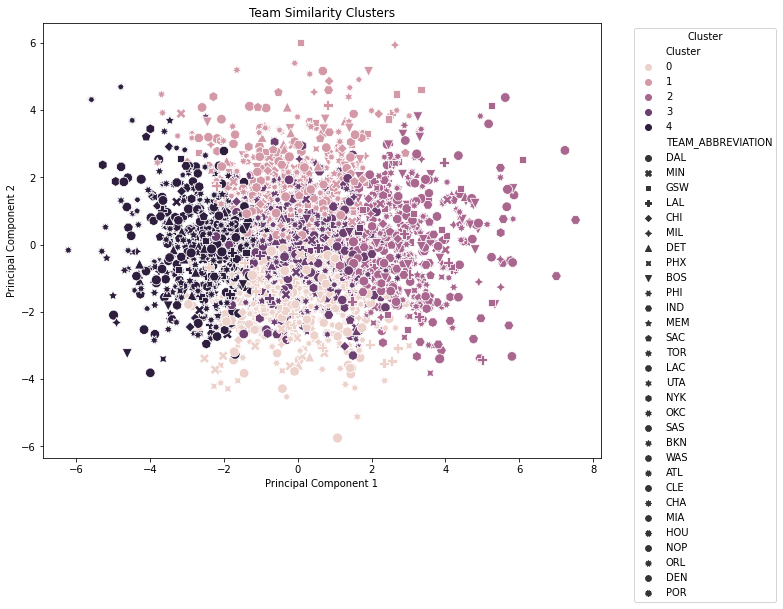

In [59]:
team_game_stats = team_stats.groupby(['GAME_ID', 'TEAM_ABBREVIATION']).agg({
    'FGM': 'sum', 'FGA': 'sum', 'FG_PCT': 'mean',
    'FG3M': 'sum', 'FG3A': 'sum', 'FG3_PCT': 'mean',
    'FTM': 'sum', 'FTA': 'sum', 'FT_PCT': 'mean',
    'OREB': 'sum', 'DREB': 'sum', 'REB': 'sum',
    'AST': 'sum', 'STL': 'sum', 'BLK': 'sum',
    'TOV': 'sum', 'PF': 'sum', 'PTS': 'sum'
}).reset_index()

# Normalize the data
scaler = StandardScaler()
normalized_stats = scaler.fit_transform(team_game_stats.drop(['GAME_ID', 'TEAM_ABBREVIATION'], axis=1))

# Perform clustering (K-means)
n_clusters = 5  # Specify the desired number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(normalized_stats)

# Add cluster labels to the data
team_game_stats['Cluster'] = clusters

# Perform dimensionality reduction (PCA)
pca = PCA(n_components=2)
pca_stats = pca.fit_transform(normalized_stats)

# Create a DataFrame with PCA components and team information
pca_df = pd.DataFrame(data=pca_stats, columns=['PC1', 'PC2'])
pca_df['TEAM_ABBREVIATION'] = team_game_stats['TEAM_ABBREVIATION']
pca_df['Cluster'] = team_game_stats['Cluster']

# Visualize the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', style='TEAM_ABBREVIATION', s=100)
plt.title('Team Similarity Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [60]:
team_stats['TEAM_ABBREVIATION'] = team_stats['TEAM_ABBREVIATION'].apply(lambda x: x[:3])  # Extract the first 3 characters

In [61]:
team_game_stats.head()

,GAME_ID,TEAM_ABBREVIATION,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,...,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,Cluster
0,0012300001,DAL,34,92,0.370,14,46,0.304,17,30,...,7,35,42,18,11,8,13,25,99,4
1,0012300001,MIN,42,95,0.442,11,35,0.314,16,22,...,11,45,56,28,7,12,16,20,111,1
2,0012300002,DAL,35,94,0.372,14,46,0.304,12,17,...,15,36,51,19,8,6,20,15,96,1
3,0012300002,MIN,39,90,0.433,14,31,0.452,12,16,...,13,33,46,25,9,8,18,23,104,3
4,0012300003,GSW,46,98,0.469,17,48,0.354,16,25,...,11,50,61,27,11,8,19,20,125,1


In [62]:
# Aggregate team stats for each game
team_game_stats = team_stats.groupby(['GAME_ID', 'TEAM_ABBREVIATION']).agg({
    'FGM': 'sum', 'FGA': 'sum', 'FG_PCT': 'mean',
    'FG3M': 'sum', 'FG3A': 'sum', 'FG3_PCT': 'mean',
    'FTM': 'sum', 'FTA': 'sum', 'FT_PCT': 'mean',
    'OREB': 'sum', 'DREB': 'sum', 'REB': 'sum',
    'AST': 'sum', 'STL': 'sum', 'BLK': 'sum',
    'TOV': 'sum', 'PF': 'sum', 'PTS': 'sum'
}).reset_index()

# Aggregate team stats across all games
team_season_stats = team_game_stats.groupby('TEAM_ABBREVIATION').mean().reset_index()

# Display the team season averages
print("Team Season Averages:")
print(team_season_stats)

Team Season Averages:
   TEAM_ABBREVIATION GAME_ID        FGM        FGA    FG_PCT       FG3M  \
0                ATL     inf  42.795455  92.102273  0.465648  13.613636   
1                BKN     inf  40.697674  89.058140  0.457733  13.441860   
2                BOS     inf  43.473118  89.645161  0.485538  16.279570   
3                CHA     inf  39.941860  87.162791  0.459535  11.872093   
4                CHI     inf  42.056180  89.898876  0.469270  11.505618   
5                CLE     inf  41.221053  86.684211  0.475779  13.157895   
6                DAL     inf  42.478723  89.297872  0.476170  14.446809   
7                DEN     inf  43.500000  88.553191  0.492096  11.723404   
8                DET     inf  40.988372  88.372093  0.464477  11.139535   
9                GSW     inf  43.534091  91.477273  0.477023  14.738636   
10               HOU     inf  41.597701  90.862069  0.458149  12.563218   
11               IND     inf  46.357895  92.515789  0.502358  13.210526   
12 

In [63]:
team_stats = team_stats.drop('GAME_ID', axis=1)

In [64]:
# Clean the 'TEAM_ABBREVIATION' column
team_stats['TEAM_ABBREVIATION'] = team_stats['TEAM_ABBREVIATION'].apply(lambda x: x[:3])  # Extract the first 3 characters

# Aggregate team stats across all games
team_overall_stats = team_stats.groupby('TEAM_ABBREVIATION').mean().reset_index()

# Check for and remove rows with infinity or NaN values
team_overall_stats = team_overall_stats.replace([np.inf, -np.inf], np.nan).dropna()

# Normalize the data
scaler = StandardScaler()
normalized_stats = scaler.fit_transform(team_overall_stats.drop(['TEAM_ABBREVIATION'], axis=1))

# Perform clustering (K-means)
n_clusters = 5  # Specify the desired number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(normalized_stats)

# Add cluster labels to the data
team_overall_stats['Cluster'] = clusters

# Perform dimensionality reduction (PCA)
pca = PCA(n_components=2)
pca_stats = pca.fit_transform(normalized_stats)

# Create a DataFrame with PCA components and team information
pca_df = pd.DataFrame(data=pca_stats, columns=['PC1', 'PC2'])
pca_df['TEAM_ABBREVIATION'] = team_overall_stats['TEAM_ABBREVIATION']
pca_df['Cluster'] = team_overall_stats['Cluster']

# Visualize the clusters
plt.figure(figsize=(10, 8))
for cluster in range(n_clusters):
    cluster_data = pca_df[pca_df['Cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}')
    
    # Add team abbreviations as labels
    for idx, row in cluster_data.iterrows():
        plt.annotate(row['TEAM_ABBREVIATION'], (row['PC1'], row['PC2']), xytext=(5, 5), textcoords='offset points')

plt.title('Team Similarity Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

# Print the list of teams in each cluster
for cluster in range(n_clusters):
    cluster_teams = team_overall_stats[team_overall_stats['Cluster'] == cluster]['TEAM_ABBREVIATION'].tolist()
    print(f"Cluster {cluster}: {', '.join(cluster_teams)}")

TypeError: Could not convert Atlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta HawksAtlanta Hawks to numeric

## Players

In [ ]:
# Get all players
nba_players = players.get_players()

# Select a specific player
player = [player for player in nba_players if player['full_name'] == 'LeBron James'][0]
player_id = player['id']

# Get the player's game logs
gamelog = playergamelog.PlayerGameLog(player_id=player_id, season='2020-21')
games = gamelog.get_data_frames()[0]

# Analyze the player's data
print(games.columns)

Index(['SEASON_ID', 'Player_ID', 'Game_ID', 'GAME_DATE', 'MATCHUP', 'WL',
       'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
       'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE'],
      dtype='object')


In [ ]:
# Nikola Jokić
career = playercareerstats.PlayerCareerStats(player_id='203999') 

# pandas data frames (optional: pip install pandas)
career.get_data_frames()[0]

# json
career.get_json()

# dictionary
career.get_dict()

{'resource': 'playercareerstats',
 'parameters': {'PerMode': 'Totals', 'PlayerID': 203999, 'LeagueID': None},
 'resultSets': [{'name': 'SeasonTotalsRegularSeason',
   'headers': ['PLAYER_ID',
    'SEASON_ID',
    'LEAGUE_ID',
    'TEAM_ID',
    'TEAM_ABBREVIATION',
    'PLAYER_AGE',
    'GP',
    'GS',
    'MIN',
    'FGM',
    'FGA',
    'FG_PCT',
    'FG3M',
    'FG3A',
    'FG3_PCT',
    'FTM',
    'FTA',
    'FT_PCT',
    'OREB',
    'DREB',
    'REB',
    'AST',
    'STL',
    'BLK',
    'TOV',
    'PF',
    'PTS'],
   'rowSet': [[203999,
     '2015-16',
     '00',
     1610612743,
     'DEN',
     21.0,
     80,
     55,
     1733.0,
     307,
     600,
     0.512,
     28,
     84,
     0.333,
     154,
     190,
     0.811,
     181,
     379,
     560,
     189,
     79,
     50,
     104,
     208,
     796],
    [203999,
     '2016-17',
     '00',
     1610612743,
     'DEN',
     22.0,
     73,
     59,
     2038.0,
     494,
     854,
     0.578,
     45,
     139,
     0.

## Live Data

In [ ]:


# Today's Score Board
games = scoreboard.ScoreBoard()

# json
games.get_json()

# dictionary
games.get_dict()

{'meta': {'version': 1,
  'request': 'https://nba-prod-us-east-1-mediaops-stats.s3.amazonaws.com/NBA/liveData/scoreboard/todaysScoreboard_00.json',
  'time': '2024-05-01 12:46:04.464',
  'code': 200},
 'scoreboard': {'gameDate': '2024-05-01',
  'leagueId': '00',
  'leagueName': 'National Basketball Association',
  'games': [{'gameId': '0042300105',
    'gameCode': '20240501/MIABOS',
    'gameStatus': 1,
    'gameStatusText': '7:30 pm ET',
    'period': 0,
    'gameClock': '',
    'gameTimeUTC': '2024-05-01T23:30:00Z',
    'gameEt': '2024-05-01T19:30:00Z',
    'regulationPeriods': 4,
    'ifNecessary': False,
    'seriesGameNumber': 'Game 5',
    'gameLabel': 'East - First Round',
    'gameSubLabel': 'Game 5',
    'seriesText': 'BOS leads 3-1',
    'seriesConference': 'East',
    'poRoundDesc': 'First Round',
    'gameSubtype': '',
    'homeTeam': {'teamId': 1610612738,
     'teamName': 'Celtics',
     'teamCity': 'Boston',
     'teamTricode': 'BOS',
     'wins': 3,
     'losses': 1,
  

### Pulling Player Data

In [ ]:


# Anthony Davis
career = playercareerstats.PlayerCareerStats(player_id="203076")
career.get_data_frames()[0]

,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,203076,2012-13,00,1610612740,NOH,20.0,64,60,1846.0,349,...,0.751,165,357,522,63,75,112,89,158,867
1,203076,2013-14,00,1610612740,NOP,21.0,67,66,2358.0,522,...,0.791,207,466,673,105,89,189,109,200,1394
2,203076,2014-15,00,1610612740,NOP,22.0,68,68,2455.0,642,...,0.805,173,523,696,149,100,200,95,141,1656
3,203076,2015-16,00,1610612740,NOP,23.0,61,61,2164.0,560,...,0.758,130,497,627,116,78,125,121,148,1481
4,203076,2016-17,00,1610612740,NOP,24.0,75,75,2708.0,770,...,0.802,172,712,884,157,94,167,181,168,2099
5,203076,2017-18,00,1610612740,NOP,25.0,75,75,2727.0,780,...,0.828,187,644,831,174,115,193,162,159,2110
6,203076,2018-19,00,1610612740,NOP,26.0,56,56,1850.0,530,...,0.794,174,498,672,218,88,135,112,132,1452
7,203076,2019-20,00,1610612747,LAL,27.0,62,62,2131.0,551,...,0.846,142,435,577,200,91,143,154,156,1618
8,203076,2020-21,00,1610612747,LAL,28.0,36,36,1162.0,301,...,0.738,62,224,286,110,45,59,74,60,786
9,203076,2021-22,00,1610612747,LAL,29.0,40,40,1404.0,370,...,0.713,106,288,394,122,49,90,82,97,927


In [ ]:
from nba_api.stats.static import teams

# get_teams returns a list of 30 dictionaries, each an NBA team.
nba_teams = teams.get_teams()
print("Number of teams fetched: {}".format(len(nba_teams)))
nba_teams[:3]

Number of teams fetched: 30


[{'id': 1610612737,
  'full_name': 'Atlanta Hawks',
  'abbreviation': 'ATL',
  'nickname': 'Hawks',
  'city': 'Atlanta',
  'state': 'Georgia',
  'year_founded': 1949},
 {'id': 1610612738,
  'full_name': 'Boston Celtics',
  'abbreviation': 'BOS',
  'nickname': 'Celtics',
  'city': 'Boston',
  'state': 'Massachusetts',
  'year_founded': 1946},
 {'id': 1610612739,
  'full_name': 'Cleveland Cavaliers',
  'abbreviation': 'CLE',
  'nickname': 'Cavaliers',
  'city': 'Cleveland',
  'state': 'Ohio',
  'year_founded': 1970}]

In [ ]:
from nba_api.stats.static import players

# get_players returns a list of dictionaries, each representing a player.
nba_players = players.get_players()
print("Number of players fetched: {}".format(len(nba_players)))
nba_players[:5]

Number of players fetched: 4900


[{'id': 76001,
  'full_name': 'Alaa Abdelnaby',
  'first_name': 'Alaa',
  'last_name': 'Abdelnaby',
  'is_active': False},
 {'id': 76002,
  'full_name': 'Zaid Abdul-Aziz',
  'first_name': 'Zaid',
  'last_name': 'Abdul-Aziz',
  'is_active': False},
 {'id': 76003,
  'full_name': 'Kareem Abdul-Jabbar',
  'first_name': 'Kareem',
  'last_name': 'Abdul-Jabbar',
  'is_active': False},
 {'id': 51,
  'full_name': 'Mahmoud Abdul-Rauf',
  'first_name': 'Mahmoud',
  'last_name': 'Abdul-Rauf',
  'is_active': False},
 {'id': 1505,
  'full_name': 'Tariq Abdul-Wahad',
  'first_name': 'Tariq',
  'last_name': 'Abdul-Wahad',
  'is_active': False}]

In [ ]:
spurs = [team for team in nba_teams if team["full_name"] == "San Antonio Spurs"][0]
spurs

{'id': 1610612759,
 'full_name': 'San Antonio Spurs',
 'abbreviation': 'SAS',
 'nickname': 'Spurs',
 'city': 'San Antonio',
 'state': 'Texas',
 'year_founded': 1976}

In [ ]:
anthony_edwards = [
    player for player in nba_players if player["full_name"] == "Anthony Edwards"
][0]

rudy_gobert = [
    player for player in nba_players if player["full_name"] == "Rudy Gobert"
][0]

In [ ]:
ant_stats = playercareerstats.PlayerCareerStats(player_id="1630162")
ant_playoffs = ant_stats.get_data_frames()[2]

In [ ]:
ant_playoffs.columns

Index(['PLAYER_ID', 'SEASON_ID', 'LEAGUE_ID', 'TEAM_ID', 'TEAM_ABBREVIATION',
       'PLAYER_AGE', 'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')

In [ ]:
ant_career = playercareerstats.PlayerCareerStats(player_id="1630162")
ant_career.get_data_frames()[0]

,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,1630162,2020-21,00,1610612750,MIN,19.0,72,55,2314.0,505,...,0.776,59,277,336,211,82,36,160,129,1392
1,1630162,2021-22,00,1610612750,MIN,20.0,72,72,2466.0,549,...,0.786,62,281,343,275,105,46,190,164,1533
2,1630162,2022-23,00,1610612750,MIN,21.0,79,79,2841.0,707,...,0.756,47,411,458,350,125,58,259,186,1946
3,1630162,2023-24,00,1610612750,MIN,22.0,79,78,2770.0,718,...,0.836,52,378,430,405,101,42,241,141,2049


In [ ]:


# Get the team ID for the Minnesota Timberwolves
timberwolves_id = teams.find_team_by_abbreviation('MIN')['id']

# Define the season to retrieve data for
season = '2023-24'  # 2024 season

# Create a LeagueGameFinder instance for the Timberwolves and the specified season
gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=timberwolves_id, season_nullable=season)

# Get the game logs as a DataFrame
games_df = gamefinder.get_data_frames()[0]

# Filter the DataFrame to include only the Timberwolves' games
timberwolves_games_df = games_df[games_df['TEAM_ID'] == timberwolves_id]

# Extract player names and drop duplicates
player_names = timberwolves_games_df['PLAYER_NAME'].str.split('\\').str[0].drop_duplicates()

# Initialize a dictionary to store player starts
player_starts = {}

# Iterate over each player
for player in player_names:
    # Filter the DataFrame for the current player
    player_games_df = timberwolves_games_df[timberwolves_games_df['PLAYER_NAME'].str.contains(player)]
    
    # Count the number of starts for the player
    starts = len(player_games_df)
    
    # Add the player and their starts to the dictionary
    player_starts[player] = starts

# Convert the dictionary to a DataFrame
player_starts_df = pd.DataFrame.from_dict(player_starts, orient='index', columns=['STARTS'])

# Reset the index and rename the index column to 'PLAYER_NAME'
player_starts_df = player_starts_df.reset_index().rename(columns={'index': 'PLAYER_NAME'})

# Print the resulting DataFrame
print(player_starts_df)

KeyError: 'PLAYER_NAME'